Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [17]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("data/dataset/Train")
data_dir_test = pathlib.Path("data/dataset/Test")

In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [20]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# following link https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

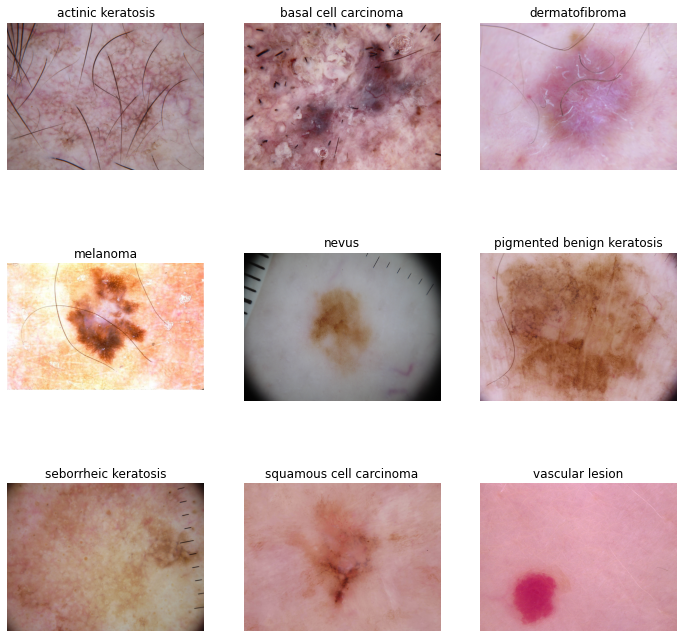

In [23]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [25]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,BatchNormalization,Flatten,Dense

### Your code goes here
model = Sequential()
# rescaling pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [26]:
### Todo, choose an appropirate optimiser and loss function

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 27s 485ms/step - loss: 2.0631 - accuracy: 0.1886 - val_loss: 2.0206 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 25s 443ms/step - loss: 1.9234 - accuracy: 0.2667 - val_loss: 1.7900 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 25s 442ms/step - loss: 1.7352 - accuracy: 0.3521 - val_loss: 1.6217 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 25s 441ms/step - loss: 1.6644 - accuracy: 0.3990 - val_loss: 1.5713 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 25s 442ms/step - loss: 1.6247 - accuracy: 0.4191 - val_loss: 1.6055 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 25s 442ms/step - loss: 1.5205 - accuracy: 0.4648 - val_loss: 1.5361 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 25s 451ms/step - loss: 1.5337 - accuracy: 0.4660 - val_loss: 1.4646 - val_accuracy: 0.5011

### Visualizing training results

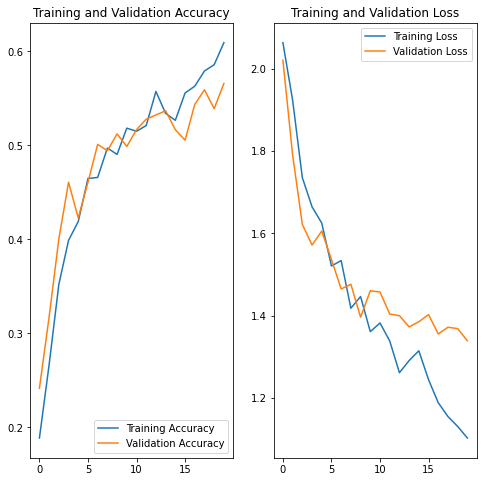

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Findings:
1. The training accuracy and validation accuracy were increasing simultaneously till epoch 10. But after that, the validation accuracy was not increasing although training accuracy was increasing. This suggests a slight overfitting.
2. Also, the training accuracy did not exceed 0.65 hence there is need to provide more dataset as well.
3. Training loss keeps on getting low but validation loss was not getting low after epoch 10.

Applying augumentation strategy by doing preprocessing like rotating,flipping,shifting,zooming,changing brightness,contrast, hue etc.

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3),seed=123),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3)
  ]
)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


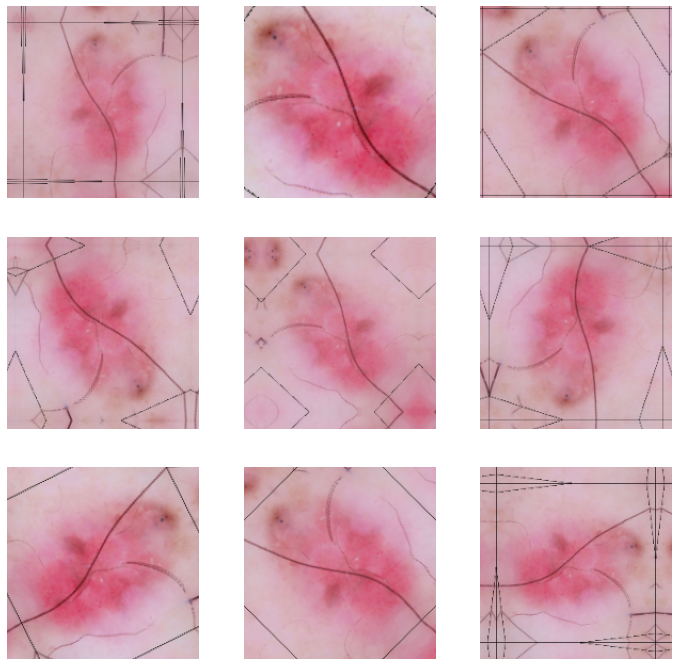

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(20):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings### Your code goes here
model = Sequential()
# rescaling pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# adding data augmentation
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


### Compiling the model

In [33]:
## Your code goes here
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 45, 45, 32)       

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 27s 486ms/step - loss: 2.0862 - accuracy: 0.1892 - val_loss: 2.0495 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 27s 483ms/step - loss: 2.0231 - accuracy: 0.2115 - val_loss: 1.9585 - val_accuracy: 0.2260
Epoch 3/20
56/56 [==============================] - 27s 481ms/step - loss: 1.9528 - accuracy: 0.2561 - val_loss: 1.8896 - val_accuracy: 0.3065
Epoch 4/20
56/56 [==============================] - 27s 490ms/step - loss: 1.8670 - accuracy: 0.3025 - val_loss: 1.9273 - val_accuracy: 0.2774
Epoch 5/20
56/56 [==============================] - 27s 480ms/step - loss: 1.7201 - accuracy: 0.3544 - val_loss: 1.6198 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 27s 480ms/step - loss: 1.6465 - accuracy: 0.3817 - val_loss: 1.7833 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 27s 478ms/step - loss: 1.6685 - accuracy: 0.3728 - val_loss: 1.5772 - val_accuracy: 0.3915

### Visualizing the results

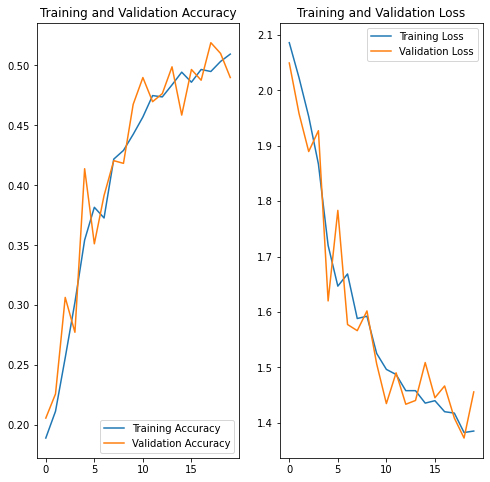

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**
1. Both training and validation accuracy are increasing with number of epochs but there is fluctuation in validation dataset.
2. Also, the training loss is decreasing but there is a big fluctuation in validation loss.
3. Overfitting issue is resolved.

The training accuracy is still less hence this is an indication of underfitting. We will again train the model after appending augmentation dataset to increase the dataset size.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

,class,number
0,actinic keratosis,114.0
1,basal cell carcinoma,376.0
2,dermatofibroma,95.0
3,melanoma,438.0
4,nevus,357.0
5,pigmented benign keratosis,462.0
6,seborrheic keratosis,77.0
7,squamous cell carcinoma,181.0
8,vascular lesion,139.0


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis    77.0
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis   462.0

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset="data/dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data/dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6D4187908>: 100%|██████████| 500/500 [00:03<00:00, 140.08 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to data/dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6D418DA90>: 100%|██████████| 500/500 [00:03<00:00, 131.42 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to data/dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6D414F550>: 100%|██████████| 500/500 [00:03<00:00, 126.51 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to data/dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA6D40C7DD8>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to data/dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FA6F42235F8>: 100%|██████████| 500/500 [00:15<00:00, 32.06 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to data/dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6D409E4E0>: 100%|██████████| 500/500 [00:04<00:00, 121.77 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to data/dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA6D41C3C50>: 100%|██████████| 500/500 [00:07<00:00, 63.06 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to data/dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6D41CA3C8>: 100%|██████████| 500/500 [00:03<00:00, 129.26 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to data/dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6F406CEF0>: 100%|██████████| 500/500 [00:03<00:00, 127.79 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029634.jpg_53b8531e-2586-4d80-8003-e5acc3236ee4.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025948.jpg_9a0ed7a8-11b1-4f79-810c-01a67dff057c.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029533.jpg_beb89f46-a0ae-411b-8e72-3daca54ec9db.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031012.jpg_b1ae4bfa-0019-490c-8257-d0ef271cb438.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028232.jpg_3b892f59-6a1d-4db4-81f0-4d996209c9d6.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_c9b3dab6-9a17-4929-8c13-31b28e179312.jpg',
 'data/dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026132.jpg_64656474-ab2b-4c9d-af1c-0573

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [85]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [54]:
for i in class_names:
    directory ='data/dataset/Train/'
    directory_out ='data/dataset/Train/'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train="data/dataset/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here
model = Sequential()
# rescaling pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
## Your code goes here
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
# getting model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [49]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/50
169/169 [==============================] - 96s 567ms/step - loss: 2.1617 - accuracy: 0.1612 - val_loss: 2.0629 - val_accuracy: 0.1878
Epoch 2/50
169/169 [==============================] - 95s 564ms/step - loss: 1.9425 - accuracy: 0.2385 - val_loss: 1.6838 - val_accuracy: 0.3341
Epoch 3/50
169/169 [==============================] - 95s 565ms/step - loss: 1.6932 - accuracy: 0.3570 - val_loss: 1.4827 - val_accuracy: 0.4135
Epoch 4/50
169/169 [==============================] - 95s 562ms/step - loss: 1.4998 - accuracy: 0.4288 - val_loss: 1.4759 - val_accuracy: 0.4373
Epoch 5/50
169/169 [==============================] - 95s 564ms/step - loss: 1.3647 - accuracy: 0.4802 - val_loss: 1.2812 - val_accuracy: 0.5122
Epoch 6/50
169/169 [==============================] - 95s 563ms/step - loss: 1.2823 - accuracy: 0.5033 - val_loss: 1.2958 - val_accuracy: 0.5108
Epoch 7/50
169/169 [==============================] - 95s 562ms/step - loss: 1.2119 - accuracy: 0.5402 - val_loss: 1.2131 - val_ac

#### **Todo:**  Visualize the model results

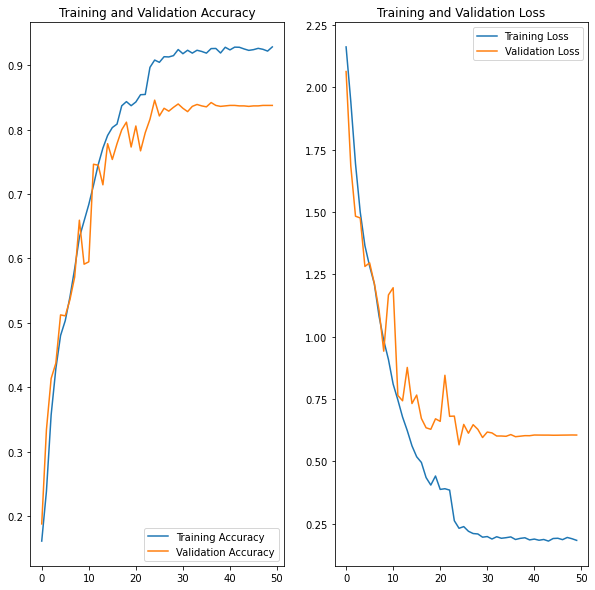

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Findings**

Looking at above graph:

1. Rebalancing resolved underfitting issue. After 20 epochs, the new Validation and training accuracy was more than 0.8 in comparison to 0.5 earlier without Rebalancing.
2. Till epoch 25, the model neither overfitting nor underfitting. After epoch 25, both training and validation set accuracy came to a halt.
3. The augmentation technique was vital for better model accuracy.

